In [0]:
import torch as th
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = "cuda" if th.cuda.is_available() else "cpu"
print(device)

cuda


In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, features):
    super(ResidualBlock, self).__init__()

    self.model = nn.Sequential(
      nn.ReflectionPad2d(1),
      nn.Conv2d(features, features, 3),
      nn.InstanceNorm2d(features),
      nn.ReLU(inplace=True),
      nn.ReflectionPad2d(1),
      nn.Conv2d(features, features, 3),
      nn.InstanceNorm2d(features))

  def forward(self, x):
    return x + self.model(x)

In [0]:
class DownsamplerBlock(nn.Module):
  def __init__(
          self, 
          input_features=3,
          start_features=64, 
          downsampling_stages=2, 
          residual_stages=2):
    super(DownsamplerBlock, self).__init__()

    # initial stage
    features = start_features
    model = [
      nn.ReflectionPad2d(3),
      nn.Conv2d(input_features, features, 7),
      nn.InstanceNorm2d(features),
      nn.ReLU(inplace=True),
    ]

    # downsampling stages
    for _ in range(downsampling_stages):
      model += [
        nn.Conv2d(features, 2 * features, 3, stride=2, padding=1),
        nn.InstanceNorm2d(2 * features),
        nn.ReLU(inplace=True),
      ]
      features *= 2

    # residual stages
    for _ in range(residual_stages):
      model += [
        ResidualBlock(features),
      ]

    # just for fun
    # model += [ nn.Tanh() ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

In [0]:
class UpsamplerBlock(nn.Module):
  def __init__(
          self,
          input_features=3,
          start_features=64, 
          downsampling_stages=2, 
          residual_stages=2):
    super(UpsamplerBlock, self).__init__()

    # residual stages
    features = start_features * (2 ** downsampling_stages)
    model = []
    for _ in range(residual_stages):
      model += [
        ResidualBlock(features),
      ]

    # upsampling stages
    for _ in range(downsampling_stages):
      features //= 2
      model += [
        nn.ConvTranspose2d(2 * features, features, 3, stride=2, padding=1, output_padding=1),
        nn.InstanceNorm2d(features),
        nn.ReLU(inplace=True)
      ]

    # final stage
    assert features == start_features
    model += [
      nn.ReflectionPad2d(3),
      nn.Conv2d(features, input_features, 7),
    ]

    # just for fun
    # model += [ nn.Tanh() ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

In [0]:
data = th.zeros([2, 3, 100, 100])
print(data.shape)
downsampler = DownsamplerBlock(input_features=3, downsampling_stages=2, residual_stages=2)
data = downsampler(data)
print(data.shape)
upsampler = UpsamplerBlock(input_features=3, downsampling_stages=2, residual_stages=2)
data = upsampler(data)
print(data.shape)

torch.Size([2, 3, 100, 100])
torch.Size([2, 256, 25, 25])
torch.Size([2, 3, 100, 100])


0 1.1876953840255737


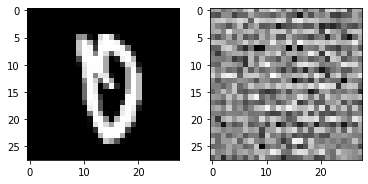

100 0.08065197616815567


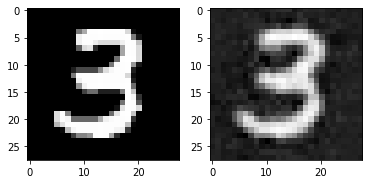

200 0.05199085548520088


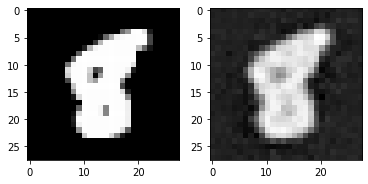

300 0.045962970703840256


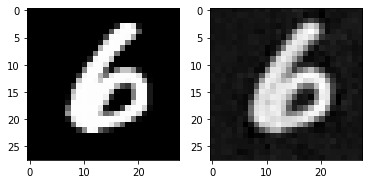

400 0.03461388871073723


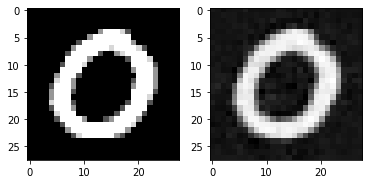

500 0.03542117029428482


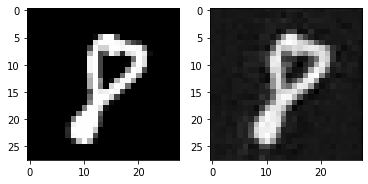

In [0]:
def mnist_training():
  training_data = datasets.MNIST(
    'data', 
    train=True, 
    download=True,
    transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.1307], [0.3081])
    ]))
  training_loader = th.utils.data.DataLoader(
    training_data,
    batch_size=100,
    shuffle=True)

  downsampler = DownsamplerBlock(
    input_features=1, 
    start_features=32).to(device)
  upsampler = UpsamplerBlock(
      input_features=1, 
      start_features=32).to(device)
  criterion = nn.MSELoss()

  optimizer = th.optim.Adam(
    list(downsampler.parameters()) + list(upsampler.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
  )
  
  for batch_idx, (data, _) in enumerate(training_loader):
    optimizer.zero_grad()
    data1 = data.to(device)
    data2 = downsampler(data1)
    data3 = upsampler(data2)
    loss = criterion(data1, data3)
    if batch_idx % 100 == 0:
      print(batch_idx, loss.item())
      fig, (ax0, ax1) = plt.subplots(1, 2)
      ax0.imshow(-data1[0, 0].cpu(), cmap='Greys')
      ax1.imshow(-data3[0, 0].detach().cpu(), cmap='Greys')
      plt.show()
    loss.backward()
    optimizer.step()

mnist_training()